In [4]:
import pandas as pd
import numpy as np

def to_month_id(year, month):
  return (year - 1996) * 12 + month - 6

n_features = 12 # or 54
lookback = 3
chosen_stocks = ["COST"] # "AMZN", "MSFT", "IBM", "INTC", "QCOM", "NVDA", "IBM", "ADBE", "EBAY", "CSCO"

In [5]:
dfFeature = pd.read_csv("./lstm_2004_12.csv")
# dfFeature.loc[dfFeature["return"] == 0, "return"] = 1
dfFeature = dfFeature[dfFeature.QAId.isin(chosen_stocks)]
features = dfFeature.drop(columns=['month_id', 'QAId']).as_matrix()
print(features.shape)

(157, 12)


In [6]:
from sklearn.preprocessing import MinMaxScaler
normalizedFeatures = MinMaxScaler().fit_transform(features) \
                                   .reshape(157, len(chosen_stocks), n_features) \
                                   .reshape(157, len(chosen_stocks) * n_features)
print(normalizedFeatures.shape)

(157, 12)


In [7]:
dfTarget = pd.read_csv("./return_2004_40.csv")
dfTarget["return"] = np.sign(dfTarget["return"])
# dfTarget.loc[dfTarget["return"] == 0, "return"] = 1
dfTarget = dfTarget[dfTarget.QAId.isin(chosen_stocks)]
dfTarget = dfTarget[dfTarget.month_id >= (to_month_id(2004, 1) + lookback)]
targets = MinMaxScaler().fit_transform(dfTarget.drop(columns=['month_id', 'QAId']).as_matrix())
y = targets.reshape(157 - lookback + 1, len(chosen_stocks))
print(y.shape)

(155, 1)


In [8]:
from keras.preprocessing.sequence import TimeseriesGenerator

splittedFeature = normalizedFeatures
print(splittedFeature.shape)

/Users/billykwok/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(157, 12)


In [9]:
from keras.preprocessing.sequence import TimeseriesGenerator

x = np.zeros((157 - lookback + 1, lookback, n_features * len(chosen_stocks)))
y_mock = np.zeros((157, len(chosen_stocks)))

i = 0
for train, test in TimeseriesGenerator(splittedFeature, y_mock, length=lookback, batch_size=1):
  if i > 157 - lookback:
    break
  x[i] = train[0]
  i = i + 1

In [10]:
from sklearn.model_selection import PredefinedSplit

test_months = 26
end_point = 157 - lookback + 1
split_point = 157 - lookback + 1 - test_months

x_train = x[0:split_point - 48].reshape(split_point - 48, lookback, n_features * len(chosen_stocks))
y_train = y[0:split_point - 48].reshape(split_point - 48, len(chosen_stocks))
x_validate = x[split_point - 36:split_point].reshape(36, lookback, n_features * len(chosen_stocks))
y_validate = y[split_point - 36:split_point].reshape(36, len(chosen_stocks))
x_test = x[split_point:end_point].reshape(test_months, lookback, n_features * len(chosen_stocks))
y_test = y[split_point:end_point].reshape(test_months, len(chosen_stocks))

print(x_train.shape)
print(y_train.shape)
print(x_validate.shape)
print(y_validate.shape)
print(x_test.shape)
print(y_test.shape)

# ps = PredefinedSplit(np.append(np.negative(np.ones(60 * 465)), np.zeros(24 * 465))).split(x_train)

# for train_ids, test_ids in ps:
#   print(str(train_ids) + ", " + str(test_ids))

(81, 3, 12)
(81, 1)
(36, 3, 12)
(36, 1)
(26, 3, 12)
(26, 1)


In [51]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Flatten, CuDNNLSTM
from keras.regularizers import l1_l2, l2
from keras.optimizers import RMSprop, Adam
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

np.random.seed(4103)

def create_model(*param):
    model = Sequential()
    model.add(LSTM(units=128, input_shape=(lookback, n_features * len(chosen_stocks)), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=128, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(len(chosen_stocks), activation="relu"))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, decay=0.0), metrics=['accuracy'], *param)
    return model

In [52]:
batch_size=30

model = create_model()
train_score = model.fit(x_train, y_train, validation_data=(x_validate, y_validate), batch_size=batch_size, epochs=200)
print(train_score)

Train on 81 samples, validate on 36 samples
Epoch 1/200
81/81 [==============================] - 3s 39ms/step - loss: 4.8505 - acc: 0.4568 - val_loss: 3.4456 - val_acc: 0.2778
Epoch 2/200
81/81 [==============================] - 0s 578us/step - loss: 2.5857 - acc: 0.4568 - val_loss: 3.0682 - val_acc: 0.2778
Epoch 3/200
81/81 [==============================] - 0s 585us/step - loss: 2.2971 - acc: 0.4568 - val_loss: 2.8638 - val_acc: 0.2778
Epoch 4/200
81/81 [==============================] - 0s 572us/step - loss: 2.1756 - acc: 0.4568 - val_loss: 2.7266 - val_acc: 0.2778
Epoch 5/200
81/81 [==============================] - 0s 581us/step - loss: 2.0652 - acc: 0.4568 - val_loss: 2.6165 - val_acc: 0.2778
Epoch 6/200
81/81 [==============================] - 0s 594us/step - loss: 1.9797 - acc: 0.4568 - val_loss: 2.5235 - val_acc: 0.2778
Epoch 7/200
81/81 [==============================] - 0s 568us/step - loss: 1.9101 - acc: 0.4568 - val_loss: 2.4400 - val_acc: 0.2778
Epoch 8/200
81/81 [=======

Epoch 62/200
81/81 [==============================] - 0s 535us/step - loss: 0.6889 - acc: 0.5062 - val_loss: 0.6412 - val_acc: 0.7222
Epoch 63/200
81/81 [==============================] - 0s 560us/step - loss: 0.6936 - acc: 0.5556 - val_loss: 0.6423 - val_acc: 0.6944
Epoch 64/200
81/81 [==============================] - 0s 542us/step - loss: 0.6791 - acc: 0.5802 - val_loss: 0.6426 - val_acc: 0.6944
Epoch 65/200
81/81 [==============================] - 0s 541us/step - loss: 0.6952 - acc: 0.4938 - val_loss: 0.6426 - val_acc: 0.6944
Epoch 66/200
81/81 [==============================] - 0s 556us/step - loss: 0.6855 - acc: 0.5432 - val_loss: 0.6445 - val_acc: 0.6667
Epoch 67/200
81/81 [==============================] - 0s 565us/step - loss: 0.6915 - acc: 0.5309 - val_loss: 0.6467 - val_acc: 0.6667
Epoch 68/200
81/81 [==============================] - 0s 538us/step - loss: 0.6832 - acc: 0.5556 - val_loss: 0.6472 - val_acc: 0.6667
Epoch 69/200
81/81 [==============================] - 0s 559us

Epoch 123/200
81/81 [==============================] - 0s 600us/step - loss: 0.6766 - acc: 0.5679 - val_loss: 0.6496 - val_acc: 0.6389
Epoch 124/200
81/81 [==============================] - 0s 583us/step - loss: 0.6918 - acc: 0.5432 - val_loss: 0.6490 - val_acc: 0.6389
Epoch 125/200
81/81 [==============================] - 0s 591us/step - loss: 0.6827 - acc: 0.5309 - val_loss: 0.6486 - val_acc: 0.6389
Epoch 126/200
81/81 [==============================] - 0s 570us/step - loss: 0.6861 - acc: 0.5309 - val_loss: 0.6476 - val_acc: 0.6389
Epoch 127/200
81/81 [==============================] - 0s 562us/step - loss: 0.6960 - acc: 0.5062 - val_loss: 0.6492 - val_acc: 0.6389
Epoch 128/200
81/81 [==============================] - 0s 544us/step - loss: 0.6933 - acc: 0.5062 - val_loss: 0.6501 - val_acc: 0.6111
Epoch 129/200
81/81 [==============================] - 0s 550us/step - loss: 0.6843 - acc: 0.5432 - val_loss: 0.6487 - val_acc: 0.6389
Epoch 130/200
81/81 [==============================] - 

Epoch 184/200
81/81 [==============================] - 0s 561us/step - loss: 0.6912 - acc: 0.5309 - val_loss: 0.6602 - val_acc: 0.6389
Epoch 185/200
81/81 [==============================] - 0s 592us/step - loss: 0.6811 - acc: 0.5309 - val_loss: 0.6595 - val_acc: 0.6389
Epoch 186/200
81/81 [==============================] - 0s 567us/step - loss: 0.6910 - acc: 0.5309 - val_loss: 0.6601 - val_acc: 0.6111
Epoch 187/200
81/81 [==============================] - 0s 589us/step - loss: 0.6805 - acc: 0.5679 - val_loss: 0.6587 - val_acc: 0.6389
Epoch 188/200
81/81 [==============================] - 0s 579us/step - loss: 0.6788 - acc: 0.5556 - val_loss: 0.6580 - val_acc: 0.6389
Epoch 189/200
81/81 [==============================] - 0s 595us/step - loss: 0.6800 - acc: 0.5062 - val_loss: 0.6571 - val_acc: 0.6389
Epoch 190/200
81/81 [==============================] - 0s 635us/step - loss: 0.6840 - acc: 0.5432 - val_loss: 0.6554 - val_acc: 0.6389
Epoch 191/200
81/81 [==============================] - 

26/26 [==============================] - 0s 202us/step
loss: 0.7061431407928467
acc: 0.5


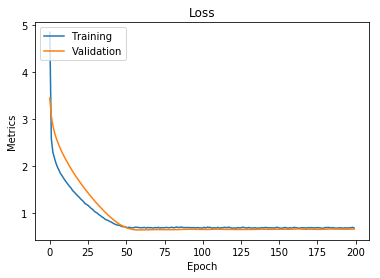

In [53]:
import matplotlib.pyplot as plt

test_score = model.evaluate(x_test, y_test, batch_size=batch_size)
for i, mn in enumerate(model.metrics_names):
  print(mn + ": " + str(test_score[i]))

plt.plot(train_score.history["loss"])
plt.plot(train_score.history["val_loss"])
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.legend(["Training", "Validation"], loc="upper left")
plt.show()

In [54]:
from sklearn.metrics import precision_score, recall_score, classification_report

def threshold_tester(result, target, a, b):
  for t in np.arange(a, b + 0.05, 0.05):
    print("thresholder: " + str(t))
    print(classification_report(target, (result >= t).astype(int)))

In [55]:
result = model.predict(x_test, batch_size=batch_size)
print(result)
threshold_tester(result, y_test, 0.1, 0.9)

[[0.44851884]
 [0.4470679 ]
 [0.44380125]
 [0.4711763 ]
 [0.44005868]
 [0.4604307 ]
 [0.4651965 ]
 [0.4881841 ]
 [0.5123998 ]
 [0.53906685]
 [0.56609386]
 [0.61974865]
 [0.5829518 ]
 [0.5453064 ]
 [0.49532506]
 [0.4975081 ]
 [0.4957299 ]
 [0.5349066 ]
 [0.54466325]
 [0.537885  ]
 [0.54404587]
 [0.5206021 ]
 [0.49285966]
 [0.464291  ]
 [0.5096214 ]
 [0.48943505]]
thresholder: 0.1
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        11
        1.0       0.58      1.00      0.73        15

avg / total       0.33      0.58      0.42        26

thresholder: 0.15000000000000002
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        11
        1.0       0.58      1.00      0.73        15

avg / total       0.33      0.58      0.42        26

thresholder: 0.20000000000000004
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        11
        1.0    

/Users/billykwok/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [56]:
import math

buy_list = []
sell_list = []

for j, stock in enumerate(chosen_stocks):
  print(stock)
  sorted_result = sorted(map(lambda x: x[j], result))
  midpt = (sorted_result[-2] + sorted_result[1]) / 2
  upper_threshold = midpt * 1.05
  lower_threshold = midpt * 0.95
  
  print("Target\tPredict\tConsequence")
  for i, r in enumerate(result):
    prediction = r[j].item()
    target = y_test[i][j].item()
    buy_or_sell = 1 if prediction > upper_threshold else (-1 if prediction < lower_threshold else 0)
    if prediction > upper_threshold:
      buy_list.append({'month_id': i + 223, 'QAId': stock})
    if prediction < lower_threshold:
      sell_list.append({'month_id': i + 223, 'QAId': stock})
    
    to_print = str(target) + "\t" + str(buy_or_sell)
    if (buy_or_sell == -1 and target == 0) or (buy_or_sell == 1 and target == 1):
      print(to_print + "\tGain")
    elif (buy_or_sell == -1 and target == 1) or (buy_or_sell == 1 and target == 0):
      print(to_print + "\tLoss")
    else:
      print(to_print + "\tNothing")
  print("\n")

print(buy_list)
print(sell_list)

COST
Target	Predict	Consequence
1.0	-1	Loss
1.0	-1	Loss
0.0	-1	Gain
0.0	-1	Gain
0.0	-1	Gain
1.0	-1	Loss
0.0	-1	Gain
1.0	0	Nothing
1.0	0	Nothing
1.0	1	Gain
1.0	1	Gain
0.0	1	Loss
0.0	1	Loss
1.0	1	Gain
0.0	0	Nothing
1.0	0	Nothing
1.0	0	Nothing
1.0	0	Nothing
0.0	1	Loss
0.0	0	Nothing
0.0	1	Loss
1.0	0	Nothing
1.0	0	Nothing
1.0	-1	Loss
1.0	0	Nothing
0.0	0	Nothing


[{'month_id': 232, 'QAId': 'COST'}, {'month_id': 233, 'QAId': 'COST'}, {'month_id': 234, 'QAId': 'COST'}, {'month_id': 235, 'QAId': 'COST'}, {'month_id': 236, 'QAId': 'COST'}, {'month_id': 241, 'QAId': 'COST'}, {'month_id': 243, 'QAId': 'COST'}]
[{'month_id': 223, 'QAId': 'COST'}, {'month_id': 224, 'QAId': 'COST'}, {'month_id': 225, 'QAId': 'COST'}, {'month_id': 226, 'QAId': 'COST'}, {'month_id': 227, 'QAId': 'COST'}, {'month_id': 228, 'QAId': 'COST'}, {'month_id': 229, 'QAId': 'COST'}, {'month_id': 246, 'QAId': 'COST'}]


In [57]:
dfBuy = pd.DataFrame(buy_list, columns=["month_id", "QAId"])
dfSell = pd.DataFrame(sell_list, columns=["month_id", "QAId"])
dfBuy.head(5)

,month_id,QAId
0,232,COST
1,233,COST
2,234,COST
3,235,COST
4,236,COST


In [58]:
dfSell.head(5)

,month_id,QAId
0,223,COST
1,224,COST
2,225,COST
3,226,COST
4,227,COST


In [59]:
filename_base = "_".join([stock.lower() for stock in chosen_stocks])
# filename_model = "./" + filename_base + "_model.h5"
# filename_weights = "./" + filename_base + "_weights.h5"
filename_output_buy = "./" + filename_base + "_output_buy.h5"
filename_output_sell = "./" + filename_base + "_output_sell.h5"

# model.save(filename_model)
# model.save_weights(filename_weights)
dfBuy.to_csv(filename_output_buy, index=False)
dfSell.to_csv(filename_output_sell, index=False)

# files.download(filename_model)
# files.download(filename_weights)
# files.download(filename_output_buy)
# files.download(filename_output_sell)